# Binary Image Mask Generator 
#### version 0.0.
### Discription:
    The goal of this script is to creat a binary masks for hight resolution and noisy images. These image concern the Versailles palace architect plans dated up to 16th and 17th century. It deals with diffrenent types of noise such as multi-color background, lumenance, contrast, text, sketch traces etc, 
### Method
* Read an image as input,
* apply gamma correction to correct the input image brightness ratio.
*
## Authors: Wassim Swaileh, Michel Jordan.
    firstname.lastname@cyu.fr
### ETIS Laboratory UMR-8051, CY Cergy Paris University, ENSEA, CNRS

# import libraries

In [1]:
%matplotlib inline
%pylab

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage import util
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage.measure import label
from skimage.color import label2rgb
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
import cv2
#from pytesseract import Output
#import pytesseract
#import argparse
from pythreshold.utils import (test_thresholds, test_thresholds_plt) #<<<<<<<
from scipy.misc import ascent
import os
#from pytesseract import Output
#import pytesseract
import argparse
import math
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.morphology import ball
from skimage.filters import rank
from datetime import datetime
start_time = datetime.now()
from PIL import Image, ImageOps

In [3]:
def transparent(myimage):
    #img = Image.open(myimage)
    img = myimage.convert("RGBA")

    pixdata = img.load()

    width, height = img.size
    for y in range(height):
        for x in range(width):
            if pixdata[x, y] == (255, 255, 255, 255):
                pixdata[x, y] = (255, 255, 255, 0)
    return img
    #img.save('test.png', "PNG")

# image reading, correcting and downsampling

1.0516494720569602


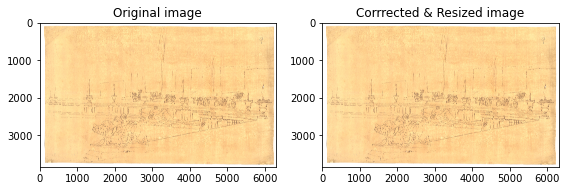

In [4]:
# Read input image

img_name = 'FRAN_0124_3925_L'
original = imread('../'+img_name+'.jpg') #/img-08-12-2020/home/jordan/Bureau/Images_Versailles_M2

# Contrast correction
logarithmic_corrected = exposure.adjust_log(original, 1)

#Gamma auto correction 
gray = cv2.cvtColor(logarithmic_corrected, cv2.COLOR_BGR2GRAY)

# compute gamma = log(mid*255)/log(mean)
mid = 0.9
mean = np.mean(gray)
gamma = math.log(mid*255)/math.log(mean)
print(gamma)

# do gamma correction
original = np.power(original, gamma).clip(0,255).astype(np.uint8)

# Input image downsampling (0%)
imge = cv2.resize(original, None, fx=1.0, fy=1.0, interpolation = cv2.INTER_CUBIC) 

# show corrections and down sampling results
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(original)
ax[0].set_title("Original image")
ax[1].imshow(imge, cmap=plt.cm.gray)
ax[1].set_title("Corrrected & Resized image")

fig.tight_layout()
plt.show()


In [5]:
def image_padding_noir(imge, desired_size=1000):
# setting the padding size

    im_pil = Image.fromarray(imge)

    old_size = im_pil.size  # old_size[0] is in (width, height) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im_pil = im_pil.resize(new_size, Image.ANTIALIAS)
    
    # create a new image and paste the resized on it
    new_img = Image.new("RGB", (desired_size, desired_size)) #
    new_img.paste(im_pil, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))
    return new_img

In [6]:
def image_padding_blanc(imge, desired_size=1000):
# setting the padding size

    im_pil = Image.fromarray(imge)

    old_size = im_pil.size  # old_size[0] is in (width, height) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im_pil = im_pil.resize(new_size, Image.ANTIALIAS)
    
    # create a new image and paste the resized on it
    new_img = Image.new("RGB", (desired_size, desired_size), (255,255,255)) #
    new_img.paste(im_pil, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))
    return new_img

In [7]:
def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

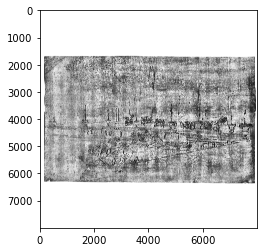

In [8]:
from PIL import Image, ImageOps
#mg = image_padding_blanc(imge, desired_size=8000)
#mg = np.asarray(img)
#plt.imshow(imge, cmap=plt.cm.gray)
# image rgb2gray conversion
grayscale = rgb2gray(imge)

# histogram equalization
grayscale = exposure.equalize_adapthist(grayscale, clip_limit=0.03)

desired_size = 8000
old_size = grayscale.shape[:2] # old_size is in (height, width) format

ratio = float(desired_size)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])

# new_size should be in (width, height) format

grayscale = cv2.resize(grayscale, (new_size[1], new_size[0]))

delta_w = desired_size - new_size[1]
delta_h = desired_size - new_size[0]
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)

#grayscale = cv2.copyMakeBorder(grayscale, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
grayscale = cv2.copyMakeBorder(grayscale, top, bottom, left, right, cv2.cv2.BORDER_REPLICATE)



plt.imshow(grayscale, cmap=plt.cm.gray)
plt.imsave("./images/"+img_name+".jpg", grayscale, cmap=plt.cm.gray)

# k-means clustering

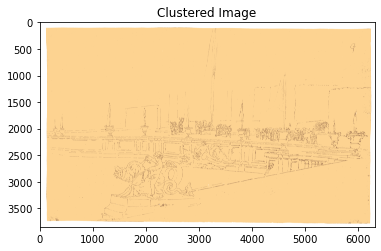

In [9]:
# For clustering the image using k-means, we first need to convert it into a 2-dimensional array
image_2D = imge.reshape(imge.shape[0]*imge.shape[1], imge.shape[2])/255

# Use KMeans clustering algorithm from sklearn.cluster to cluster pixels in image
# tweak the cluster size and see what happens to the Output
kmeans = KMeans(n_clusters=3, random_state=0).fit(image_2D)
clustered = kmeans.cluster_centers_[kmeans.labels_]

# Reshape back the image from 2D to 3D image
clustered_3D = clustered.reshape(imge.shape[0], imge.shape[1], imge.shape[2])

# Show the result
plt.imshow(clustered_3D, cmap=plt.cm.gray) #cmap=plt.cm.gray
plt.imsave(img_name+"_k-means.jpg", clustered_3D, cmap=plt.cm.gray)
plt.title('Clustered Image')
plt.show()

# rgb to gray conversion and threshoulding

type bool shape (3848, 6304)


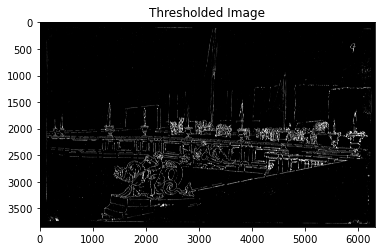

In [10]:
# image rgb2gray conversion
grayscale = rgb2gray(clustered_3D)

# histogram equalization
#grayscale = exposure.equalize_adapthist(grayscale, clip_limit=0.03)

# iversion
grayscale = util.invert(grayscale)

# bluring
blur = gaussian(grayscale, sigma=0.2)

# otsu binarisation (thresholding)
thresh = threshold_otsu(blur)
mask = closing(blur > thresh, square(3))

# show results
print('type', mask.dtype, 'shape', mask.shape)
plt.imshow(mask, cmap=plt.cm.gray)
plt.imsave("th.jpg", mask, cmap=plt.cm.gray)
plt.title('Thresholded Image')
plt.show()

# connected components thresholding

29931 1 145.782949790795 47 205.31207554074268


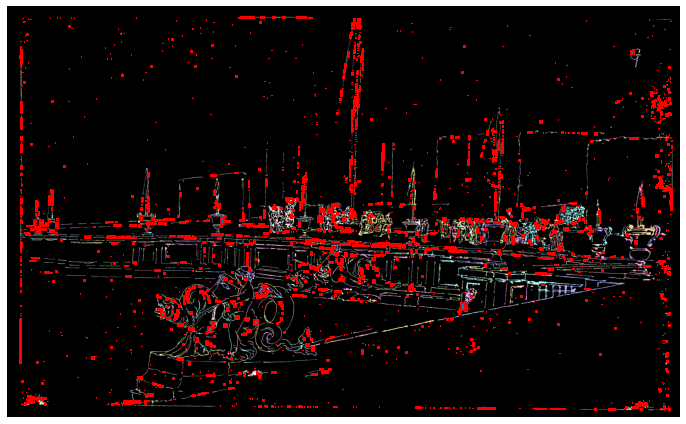

In [11]:
# remove artifacts connected to image border
cleared = clear_border(mask)

# label image regions
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=mask, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
tt = ax.imshow(image_label_overlay)

reg = []
m, n = mask.shape
img_new1 = np.zeros([m, n])
for region in regionprops(label_image):
    reg.append(region.filled_area)
av = sum(reg)/len(reg)
#reg = sorted(reg)
mx = max(reg)
mn = min(reg)
mid = sorted(reg)
mid =reg[int(len(mid)/2)]
#w = 2*(mx-min)/(mx+mn)
print(mx, mn, av, mid, mx/av)
for region in regionprops(label_image):
    #print (region.bbox)
    # take regions with large enough areas
    if region.area <= (av+mid):
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,fill=True, edgecolor='red', linewidth=2)
        image_label_overlay[minr:maxr, minc:maxc] = 0
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
#plt.imsave("tst.jpg", image_label_overlay, cmap=plt.cm.gray)
plt.show()

In [12]:
#plt.imshow(image_label_overlay)

## ROI detection and extraction using steerable oriented filters

In [13]:
def steerableFilterLayer(image, skewAngle, normFactor, widthEllipseKernel, heightEllipsKernel):
    
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(widthEllipseKernel, widthEllipseKernel))
    #padding
    #constant= cv2.copyMakeBorder(image.copy(),10,10,10,10,cv2.BORDER_CONSTANT,value=0)
    rotation = cv2.getRotationMatrix2D((widthEllipseKernel/2., heightEllipsKernel/2.), skewAngle, 1.0);
    #rotatKernel = np.zeros(widthEllipseKernel, heightEllipsKernel)
    rotatKernel = cv2.warpAffine(kernel, rotation, kernel.shape)
    rotatKernel *= normFactor
    steerableFilteredImage = cv2.filter2D(image, -1, rotatKernel, borderType=cv2.BORDER_CONSTANT)
    return steerableFilteredImage

(3848, 6304)


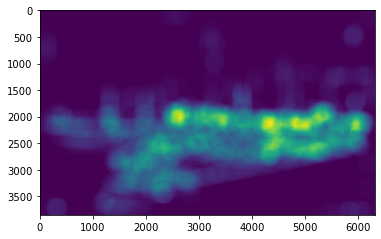

In [14]:
import math

image_label_overlay = rgb2gray(image_label_overlay)
# bluring
image_label_overlay = gaussian(image_label_overlay, sigma=0.2)

# otsu binarisation (thresholding)
thresh = threshold_otsu(image_label_overlay)
image_label_overlay = closing(image_label_overlay > thresh, square(3))
print(image_label_overlay.shape)

nn = image_label_overlay/1.
w = int((av+mid)*2)
h = int((av+mid))
m = steerableFilterLayer(nn, math.radians(25), 1, w, h)
n = m + steerableFilterLayer(nn, math.radians(20), 1, w, h)
n += steerableFilterLayer(nn, math.radians(15), 1, w, h)
n += steerableFilterLayer(nn, math.radians(10), 1, w, h)
n += steerableFilterLayer(nn, math.radians(5), 1, w, h)
n += steerableFilterLayer(nn, math.radians(0), 1, w, h)
n += steerableFilterLayer(nn, math.radians(-5), 1, w, h)
n += steerableFilterLayer(nn, math.radians(-10), 1, w, h)
n += steerableFilterLayer(nn, math.radians(-15), 1, w, h)
n += steerableFilterLayer(nn, math.radians(-20), 1, w, h)
n += steerableFilterLayer(nn, math.radians(-25), 1, w, h)
plt.imshow(n)
plt.imsave(img_name+"_steerable_filter.jpg", n, cmap=plt.cm.gray)

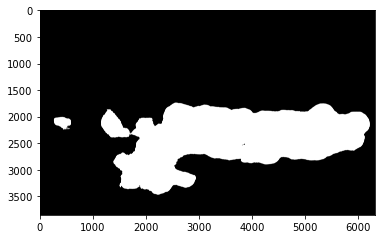

In [15]:
# otsu binarisation (thresholding)
thresh = threshold_otsu(n) # à remplacer avec un algorithm de binarisation local.
maskROI = closing(n > thresh, square(3))
plt.imshow(maskROI)
plt.imshow(maskROI, cmap=plt.cm.gray)

(3848, 6304)
Duration: 0:01:59.010408


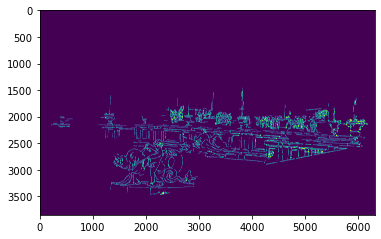

In [16]:
print(maskROI.shape)
for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    #if maskROI[minr, minc] == 0 and maskROI[maxr, maxc] == 0 and maskROI[int((maxr-minr)/2), int((maxc-minc)/2)] == 0 and maskROI[int((maxr-minr)/8), int((maxc-minc)/8)] != 0:
    if maskROI[minr:maxr, minc:maxc].any() == 0:
        image_label_overlay[minr:maxr, minc:maxc] = 0
end_time = datetime.now()
plt.imshow(image_label_overlay)
d = end_time - start_time
print('Duration: {}'.format(end_time - start_time))

#image_label_overlay = cv2.cvtColor(image_label_overlay, cv2.COLOR_BGR2RGB)
#image_label_overlay = Image.fromarray(image_label_overlay)

imgx = image_padding_noir(image_label_overlay, desired_size=8000)
imgx = np.asarray(imgx)

plt.imsave("./masks/"+img_name+"_time_"+str(d)+"_ROI.jpg", imgx, cmap=plt.cm.gray)

In [17]:
# chercher dans l'image de mask, le cadre englobant de la region d'intérêt

# inhancement suggetions

## text bounding box removing using tesseract

In [18]:
mask1 = imread('./output/cls3D_Otsu.jpg') #/ 255
#mask1 = util.invert(mask1)
mask1 = cv2.resize(mask1, None, fx=0.70, fy=0.7, interpolation = cv2.INTER_CUBIC)
results = pytesseract.image_to_data(mask1, output_type=Output.DICT)


FileNotFoundError: No such file: '/mnt/c/shared/cergy/VERSPERA/FRAN_0124_F_21_3585/Bw-Mask-Gen/output/cls3D_Otsu.jpg'

In [ ]:
min_conf = 50; #In order to filter weak text detections, a minimum confidence threshold can be provided. By default, we’ve set the threshold to 0 so that all detections are returned
#plt.imshow(mask1,  cmap=plt.cm.gray)
for i in range(0, len(results["text"])):
    # extract the bounding box coordinates of the text region from
    # the current result
    x = results["left"][i]
    y = results["top"][i]
    w = results["width"][i]
    h = results["height"][i]
    # extract the OCR text itself along with the confidence of the
    # text localization
    text = results["text"][i]
    conf = int(results["conf"][i])
# filter out weak confidence text localizations
    if conf > min_conf:
        # display the confidence and text to our terminal
        #print("Confidence: {}".format(conf))
        #print("Text: {}".format(text))
        #print("")
        # strip out non-ASCII text so we can draw the text on the image
        # using OpenCV, then draw a bounding box around the text along
        # with the text itself
        text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
        cv2.rectangle(mask1, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(mask1, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
# show the output image
#cv2.imshow("Image", img)
#cv2.waitKey(0)
plt.imsave("onePic.jpg", mask1,  cmap=plt.cm.gray)
plt.imshow(mask1,  cmap=plt.cm.gray)
plt.title('Original')
plt.show()